# CP322 – Fake News Detection with DistilBERT & XAI

This notebook gives a **lightweight, reproducible overview** of our project:

- We compare two fake-news datasets: **Kaggle** (long news articles) and **LIAR** (short political claims).
- We summarize results for **TF-IDF baselines** and a fine-tuned **DistilBERT** classifier.
- We inspect **token-level explanations** with IG, LIME, and SHAP, plus **attention**.
- We visualize quantitative **XAI quality metrics** (faithfulness & stability) and **layer probes** to see where fake/real signals emerge.
 
All results are based on **pre-computed artifacts** (metrics, explanations, and figures).  
No training is performed in this notebook.


In [ ]:
# Code Cell 1 — Imports & paths (Setup)

from pathlib import Path
import os
import json
import math
import sys
import subprocess

BASE_DIR = Path.cwd()
REQ_FILE = BASE_DIR / "requirements_minimal.txt"   # or "requirements.txt"

print("Installing from:", REQ_FILE)
subprocess.check_call([sys.executable, "-m", "pip", "install", "-r", str(REQ_FILE)])

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display, Image, Markdown

plt.style.use("default")
plt.rcParams["figure.dpi"] = 120
all_figs = []  # to keep track of all figures created


DATA_DIR = BASE_DIR / "data"
FIG_DIR = BASE_DIR / "figures"
EDA_FIG_DIR = FIG_DIR / "eda"
ATTN_FIG_DIR = FIG_DIR / "attention_vis"

ARTIFACTS_DIR = BASE_DIR / "artifacts"
METRICS_DIR = ARTIFACTS_DIR / "metrics"
EXPL_DIR = ARTIFACTS_DIR / "explanations"
LAYERS_DIR = ARTIFACTS_DIR / "layers"
DISTILBERT_DIR = ARTIFACTS_DIR / "distilbert"

print("Base directory:", BASE_DIR)



Base directory: c:\Users\anton\Documents\VSCODE PROJECTS\CP322_fake_news_xai
Installing from: c:\Users\anton\Documents\VSCODE PROJECTS\CP322_fake_news_xai\requirements_minimal.txt


0

In [46]:
# Code Cell 2 — General utilities

def show_image(path: Path, title: str | None = None, figsize=(10, 4)):
    """Display a local image with an optional title."""
    if not path.exists():
        display(Markdown(f"⚠️ **Missing figure:** `{path}`"))
        return
    if title:
        display(Markdown(f"### {title}"))
    img = Image(filename=str(path))
    display(img)


def load_json(path: Path):
    with path.open("r", encoding="utf-8") as f:
        return json.load(f)


def load_jsonl(path: Path, max_items: int | None = None):
    records = []
    if not path.exists():
        raise FileNotFoundError(path)
    with path.open("r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if max_items is not None and i >= max_items:
                break
            line = line.strip()
            if not line:
                continue
            records.append(json.loads(line))
    return records


def add_value_labels(ax, fmt="{:.3f}", spacing=3):
    """Attach numeric labels above bars in a bar chart."""
    for rect in ax.patches:
        height = rect.get_height()
        if np.isnan(height):
            continue
        ax.annotate(
            fmt.format(height),
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, spacing),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=8,
        )


## 1. Dataset exploration (EDA summary)

We work with two English fake-news datasets:

- **Kaggle**: full news articles, often hundreds of words long.
- **LIAR**: single-sentence political claims with short fact-check labels.

Below we summarize:

- Label balance in train/test.
- Text length distributions.
- Frequent content words in fake vs real news.
- “Marker” words whose frequencies differ strongly between fake and real.


### Label distribution in Kaggle vs LIAR

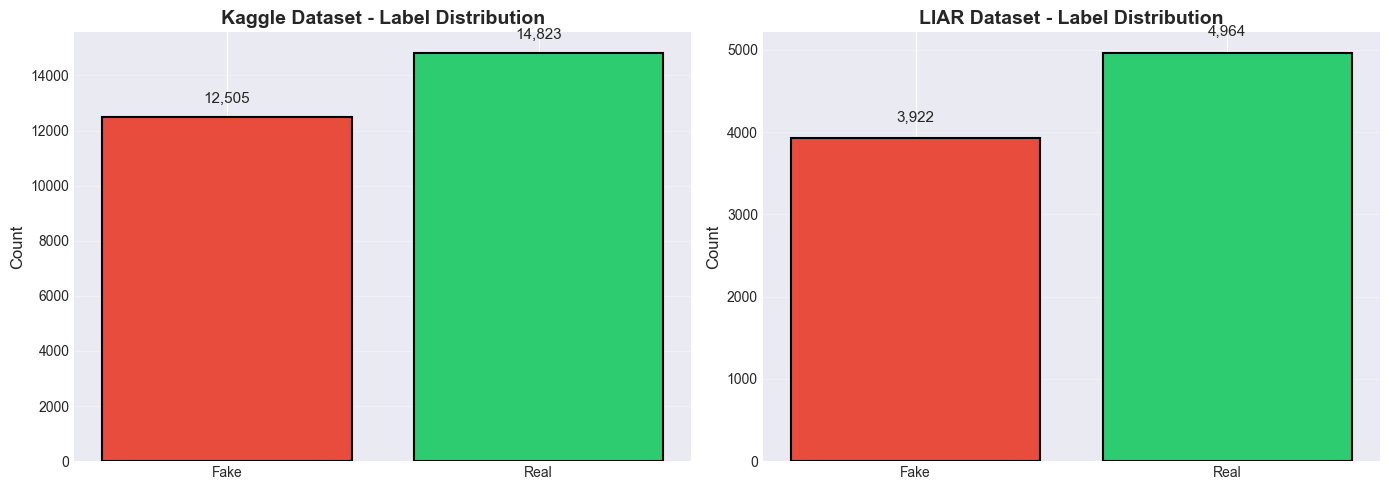

### Text length distributions (overall and by label)

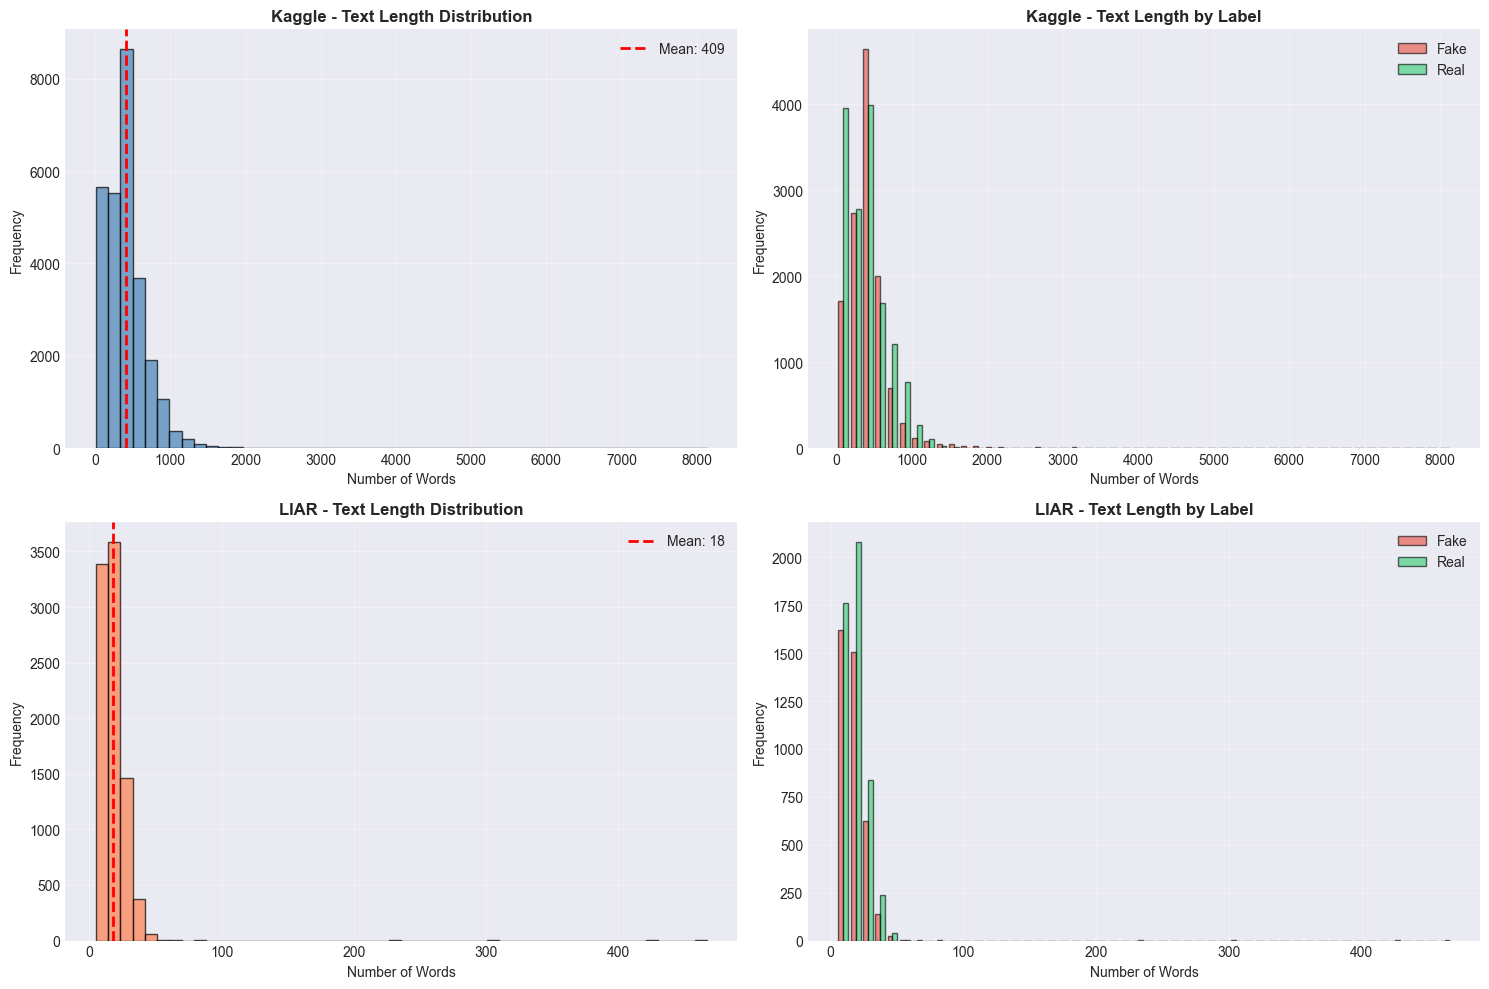

### Top 20 content words in Kaggle FAKE articles

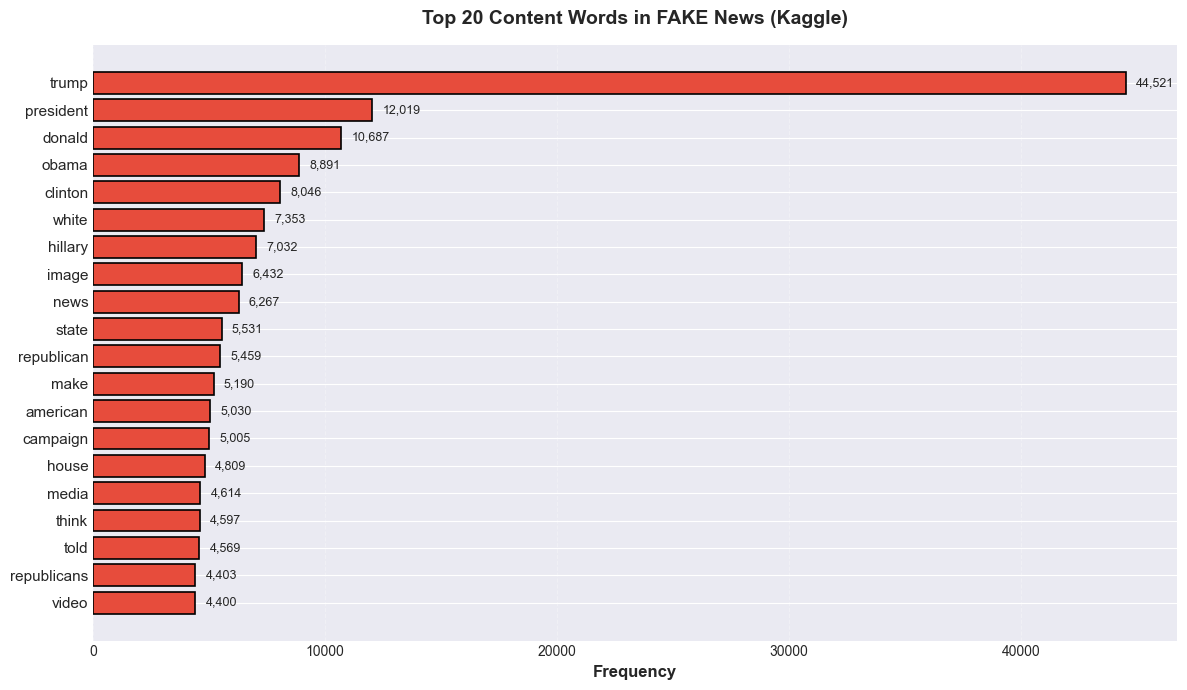

### Top 20 content words in Kaggle REAL articles

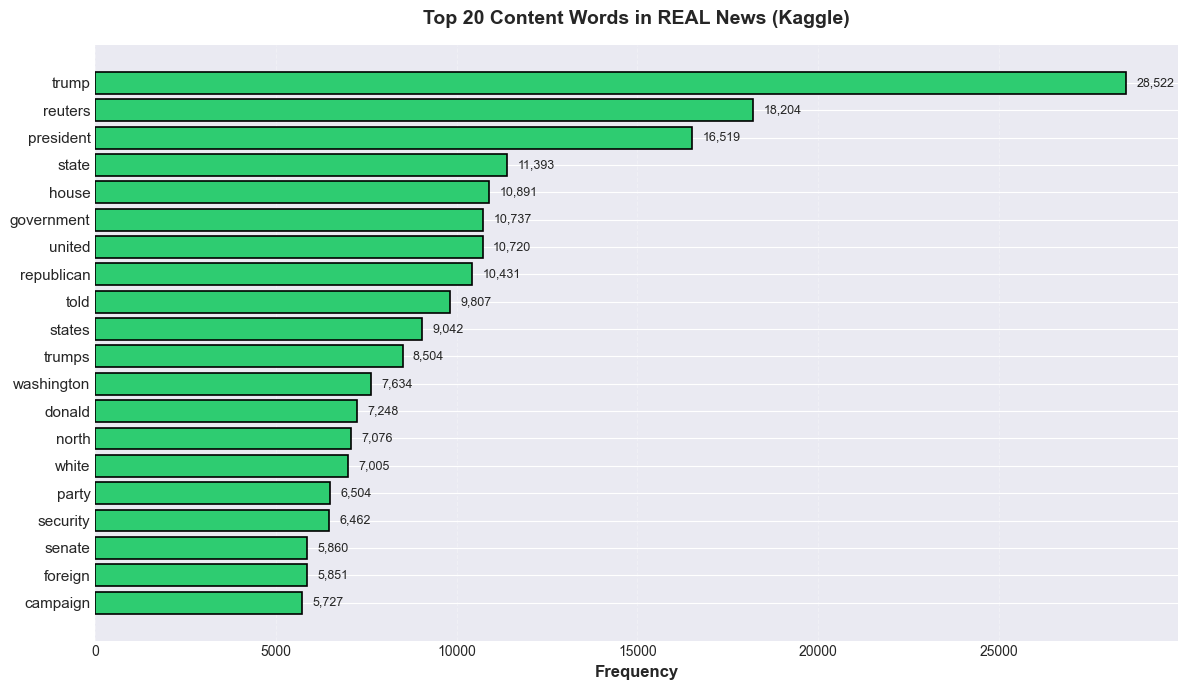

### Top 20 content words in LIAR FAKE statements

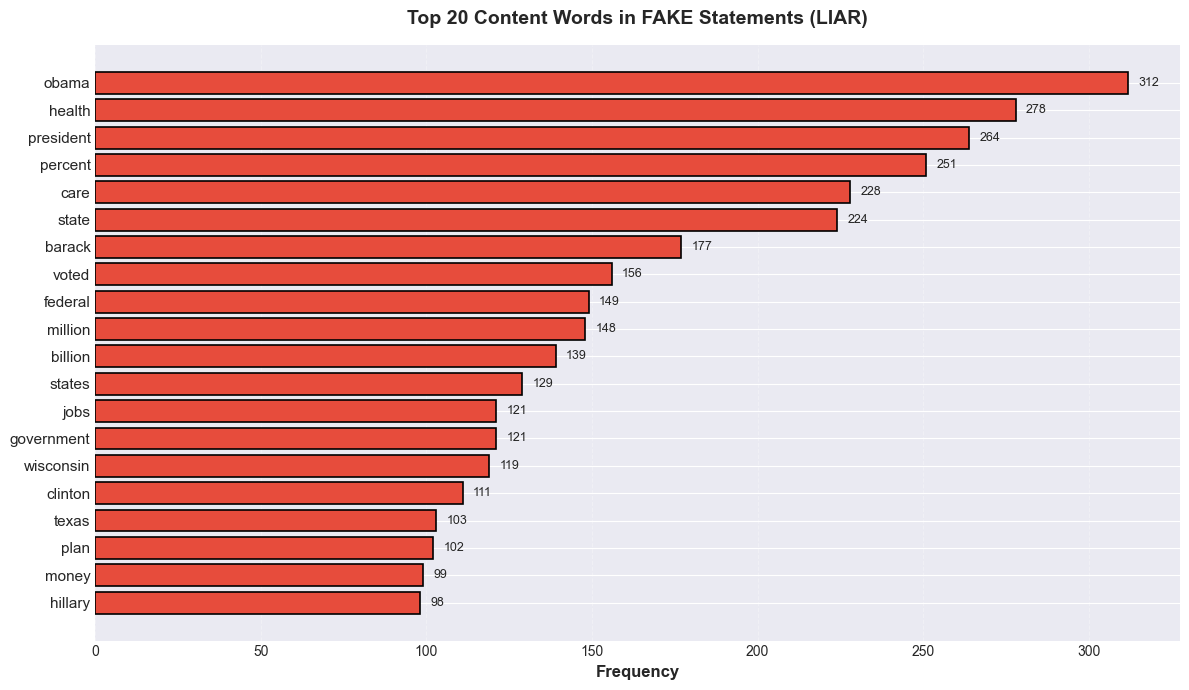

### Top 20 content words in LIAR REAL statements

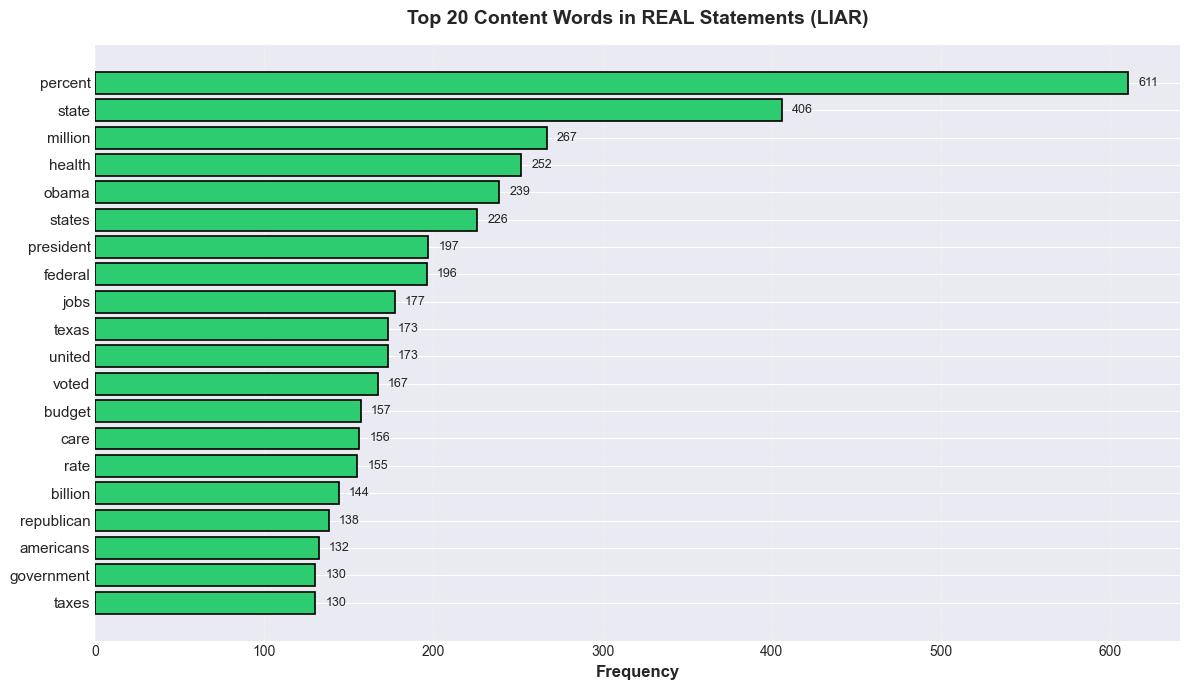

### Kaggle: top fake vs real 'marker' words

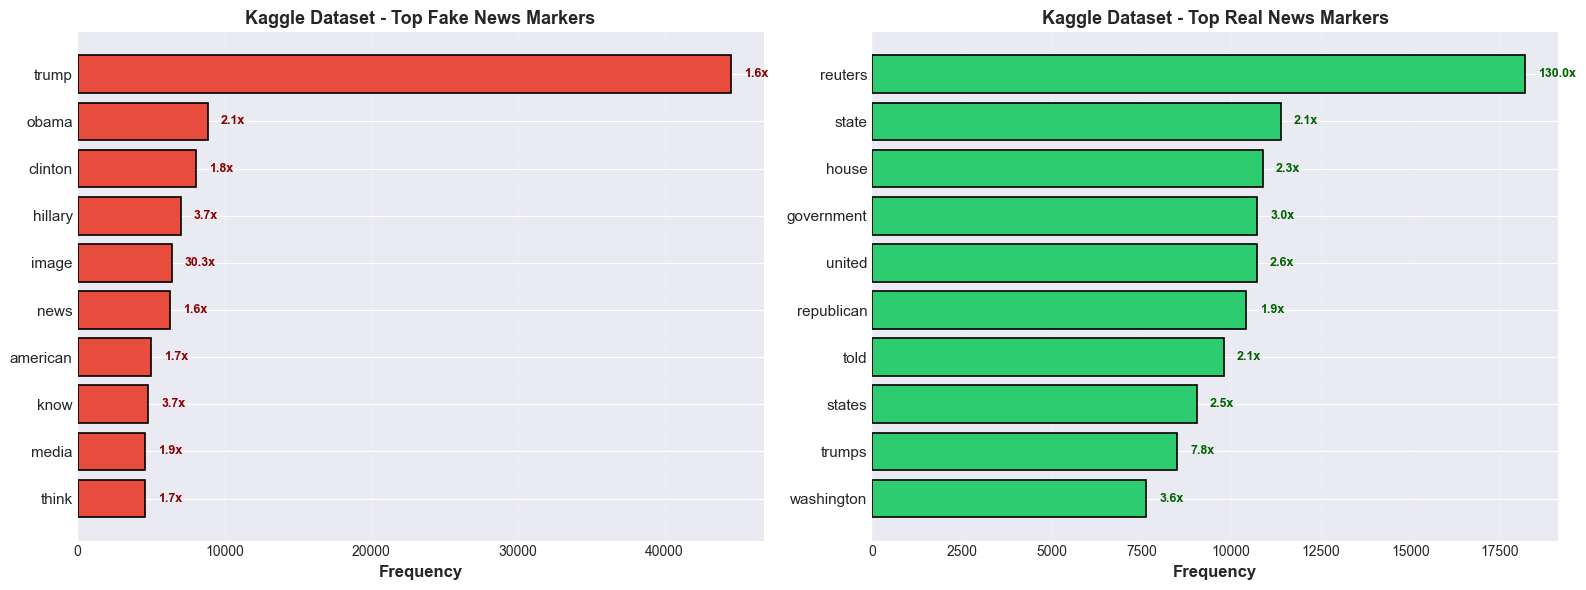

### LIAR: top fake vs real 'marker' words

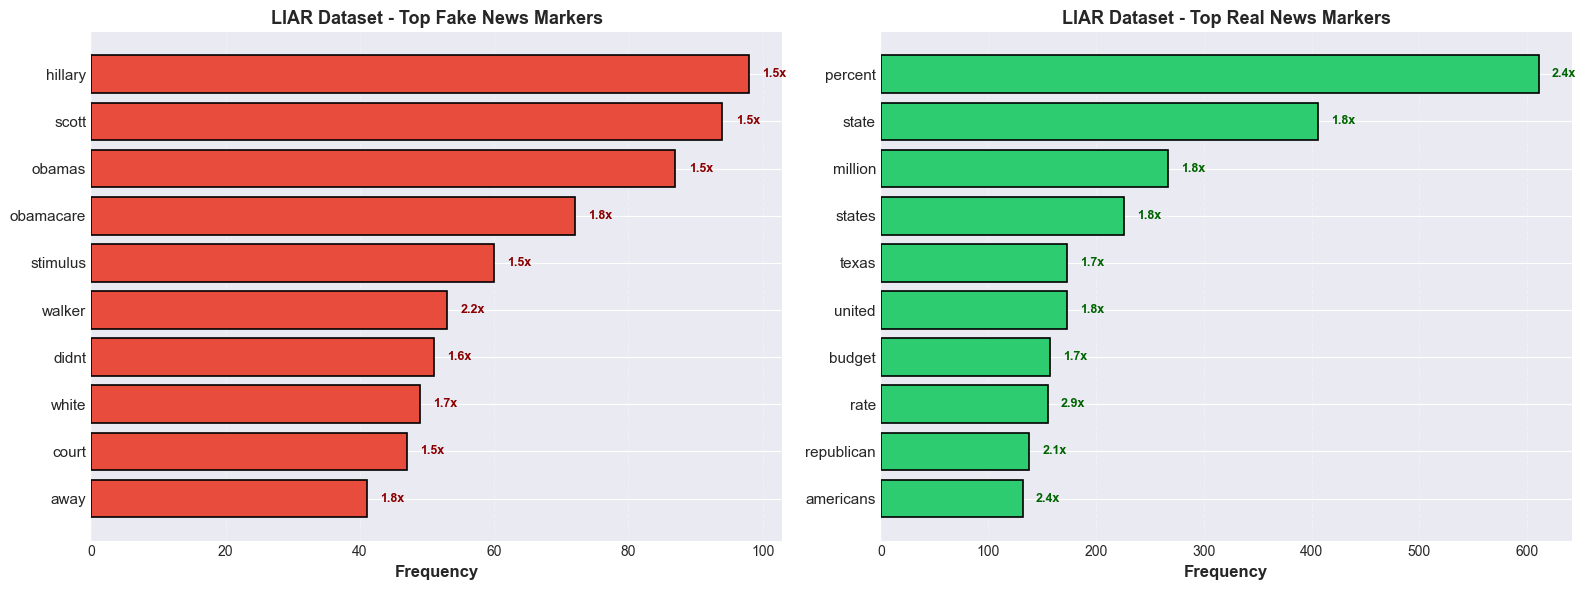

In [47]:
# Code Cell 3 — EDA figures

# 1) Label distribution (Kaggle vs LIAR)
show_image(EDA_FIG_DIR / "dataset_distribution.png",
           title="Label distribution in Kaggle vs LIAR")

# 2) Text length distributions
show_image(EDA_FIG_DIR / "test_length_distribution.png",
           title="Text length distributions (overall and by label)")

# 3) Top 20 content words per class (Kaggle)
show_image(EDA_FIG_DIR / "top_20_content_kaggle_fake.png",
           title="Top 20 content words in Kaggle FAKE articles")
show_image(EDA_FIG_DIR / "top_20_content_kaggle_real.png",
           title="Top 20 content words in Kaggle REAL articles")

# 4) Top 20 content words per class (LIAR)
show_image(EDA_FIG_DIR / "top_20_content_liar_fake.png",
           title="Top 20 content words in LIAR FAKE statements")
show_image(EDA_FIG_DIR / "top_20_content_liar_real.png",
           title="Top 20 content words in LIAR REAL statements")

# 5) Marker words (frequency ratios fake vs real)
show_image(EDA_FIG_DIR / "top_markers_kaggle.png",
           title="Kaggle: top fake vs real 'marker' words")
show_image(EDA_FIG_DIR / "top_markers_liar.png",
           title="LIAR: top fake vs real 'marker' words")


### Key observations:

- Both datasets are **roughly balanced** between Fake and Real.
- **Kaggle texts are long** (mean length ≈ hundreds of tokens), giving the model plenty of context.
- **LIAR statements are short** (mean length < 20 tokens), which makes classification harder.
- In Kaggle, clear **marker words** emerge:
  - Fake news overuses *trump*, *obama*, *image*.
  - Real news overuses *reuters* and government-related terms.
- In LIAR, differences are **much subtler**, matching the lower overall performance we’ll see later.


## 2. Baseline models (TF-IDF + classical classifiers)

Before using transformers, we trained three simple baselines:

- TF-IDF features + **Logistic Regression**
- TF-IDF + **Linear SVM**
- TF-IDF + **Random Forest**

We train on the same splits and evaluate on the same test sets as DistilBERT.

In [48]:
# Code Cell 4 — Load and show baseline results

baseline_path = METRICS_DIR / "baseline_results.csv"
baseline_df = pd.read_csv(baseline_path)
display(Markdown("**Baseline results (test set):**"))
display(baseline_df)


**Baseline results (test set):**

,dataset,model,accuracy,f1,precision,recall
0,Kaggle,TF-IDF + LogReg,0.987705,0.988706,0.985229,0.992208
1,Kaggle,TF-IDF + SVM,0.993852,0.994346,0.992009,0.996694
2,Kaggle,TF-IDF + RF,0.994621,0.995059,0.991559,0.998583
3,LIAR,TF-IDF + LogReg,0.592359,0.627832,0.640969,0.615222
4,LIAR,TF-IDF + SVM,0.572666,0.610972,0.621898,0.600423
5,LIAR,TF-IDF + RF,0.588814,0.627675,0.635379,0.620155


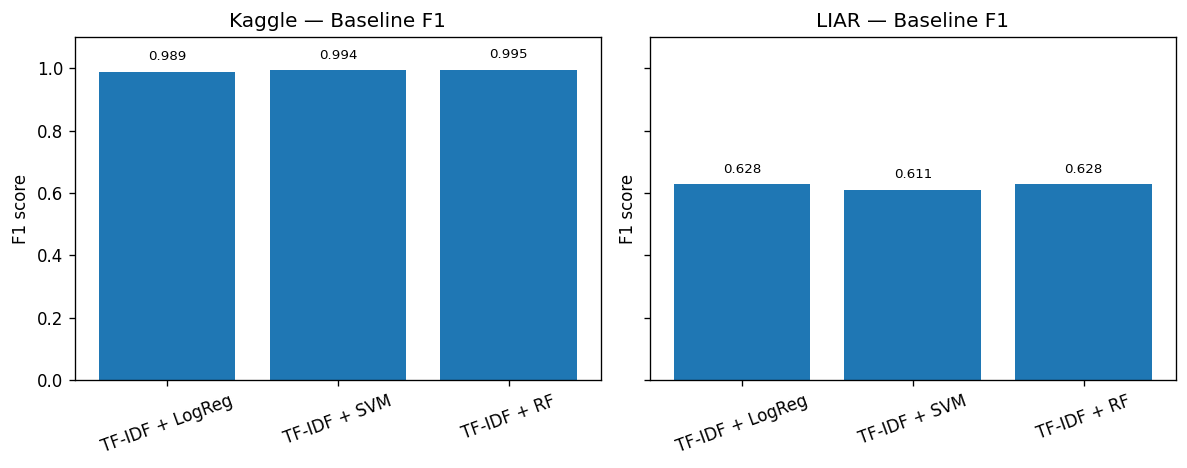

In [49]:
# Code Cell 5 — Plot baseline F1 for Kaggle vs LIAR

def plot_baseline_f1(df: pd.DataFrame, dataset: str, ax):
    sub = df[df["dataset"] == dataset].copy()
    models = sub["model"].tolist()
    f1 = sub["f1"].values

    ax.bar(models, f1)
    ax.set_title(f"{dataset} — Baseline F1")
    ax.set_ylim(0.0, 1.10)
    ax.set_ylabel("F1 score")
    ax.tick_params(axis="x", rotation=20)
    add_value_labels(ax, fmt="{:.3f}", spacing=5)


fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
all_figs.append(fig)
plot_baseline_f1(baseline_df, "Kaggle", axes[0])
plot_baseline_f1(baseline_df, "LIAR", axes[1])
plt.tight_layout()
plt.show()


### Baseline interpretation

- On **Kaggle**, all three TF-IDF models already achieve very high F1 (≈0.99).
- On **LIAR**, the best baseline F1 is around **0.63**, reflecting the difficulty of classifying short, ambiguous statements.
- DistilBERT needs to **match or beat** these baselines to justify its complexity.


## 3. DistilBERT training summary

We fine-tuned **DistilBERT-base-uncased** separately on:

- **Kaggle fake news** (long articles)
- **LIAR fake news** (short claims)

Here we load the saved metrics and chosen hyperparameters for each run.

In [50]:
# Code Cell 6 — Load DistilBERT metrics & hyperparameters

kaggle_res_path = METRICS_DIR / "distilbert_kaggle_fake_news_results.json"
liar_res_path = METRICS_DIR / "distilbert_liar_results.json"

kaggle_res = load_json(kaggle_res_path)
liar_res = load_json(liar_res_path)

distilbert_summary_rows = []

for name, res in [("Kaggle", kaggle_res), ("LIAR", liar_res)]:
    distilbert_summary_rows.append(
        {
            "dataset": name,
            "model": "DistilBERT",
            "test_accuracy": res["test_accuracy"],
            "test_f1": res["test_f1"],
            "test_precision": res["test_precision"],
            "test_recall": res["test_recall"],
        }
    )

distilbert_df = pd.DataFrame(distilbert_summary_rows)
display(Markdown("**DistilBERT test performance:**"))
display(distilbert_df)

display(Markdown("**DistilBERT hyperparameters (per dataset):**"))

for name, res in [("Kaggle", kaggle_res), ("LIAR", liar_res)]:
    hp = res.get("hyperparameters", {})
    display(Markdown(
        f"- **{name}**: " +
        ", ".join(f"`{k}={v}`" for k, v in hp.items())
    ))


**DistilBERT test performance:**

,dataset,model,test_accuracy,test_f1,test_precision,test_recall
0,Kaggle,DistilBERT,0.999232,0.999292,0.999056,0.999528
1,LIAR,DistilBERT,0.612446,0.708876,0.610913,0.844257


**DistilBERT hyperparameters (per dataset):**

- **Kaggle**: `learning_rate=2e-05`, `batch_size=16`, `epochs=3`, `max_length=512`, `weight_decay=0.01`, `warmup_steps=500`

- **LIAR**: `learning_rate=3e-05`, `batch_size=32`, `epochs=5`, `max_length=128`, `weight_decay=0.01`, `warmup_steps=200`

### Loading Pre-Trained DistilBERT
**Optional (CPU-only OK):** The cell below shows how we load a saved checkpoint and run
a quick smoke-test prediction.  
This is not required to inspect the rest of the notebook.


In [51]:
# Code Cell 7 — Optional: load a saved model and run a single prediction

try:
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    import torch

    kaggle_model_dir = ARTIFACTS_DIR / "distilbert" / "kaggle" / "final_model"
    tokenizer = AutoTokenizer.from_pretrained(kaggle_model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(kaggle_model_dir)

    example_text = "Reuters reports that the government passed a new budget bill."
    enc = tokenizer(example_text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        logits = model(**enc).logits
        probs = torch.softmax(logits, dim=-1).squeeze(0).numpy()

    display(Markdown(
        f"Example prediction on Kaggle model:\n\n"
        f"- Text: `{example_text}`\n"
        f"- Prob(Fake) = {probs[0]:.3f}, Prob(Real) = {probs[1]:.3f}"
    ))
except Exception as e:
    display(Markdown(f"⚠️ Could not run the optional prediction cell: {e}"))


Example prediction on Kaggle model:

- Text: `Reuters reports that the government passed a new budget bill.`
- Prob(Fake) = 0.000, Prob(Real) = 1.000

## 4. DistilBERT vs TF-IDF baselines

Next we compare **DistilBERT** against the three TF-IDF baselines on each dataset,
focusing on F1 as our main metric.


In [52]:
# Code Cell 8 — Merge baseline + DistilBERT and plot comparison

def build_comparison_df(baseline_df, distilbert_df):
    # Align column names
    base = baseline_df.rename(
        columns={"accuracy": "test_accuracy", "f1": "test_f1",
                 "precision": "test_precision", "recall": "test_recall"}
    ).copy()
    return pd.concat(
        [
            base,
            distilbert_df.rename(columns={"dataset": "dataset"}),
        ],
        ignore_index=True,
        sort=False,
    )

all_models_df = build_comparison_df(baseline_df, distilbert_df)
display(Markdown("**All models (baselines + DistilBERT):**"))
display(all_models_df)


**All models (baselines + DistilBERT):**

,dataset,model,test_accuracy,test_f1,test_precision,test_recall
0,Kaggle,TF-IDF + LogReg,0.987705,0.988706,0.985229,0.992208
1,Kaggle,TF-IDF + SVM,0.993852,0.994346,0.992009,0.996694
2,Kaggle,TF-IDF + RF,0.994621,0.995059,0.991559,0.998583
3,LIAR,TF-IDF + LogReg,0.592359,0.627832,0.640969,0.615222
4,LIAR,TF-IDF + SVM,0.572666,0.610972,0.621898,0.600423
5,LIAR,TF-IDF + RF,0.588814,0.627675,0.635379,0.620155
6,Kaggle,DistilBERT,0.999232,0.999292,0.999056,0.999528
7,LIAR,DistilBERT,0.612446,0.708876,0.610913,0.844257


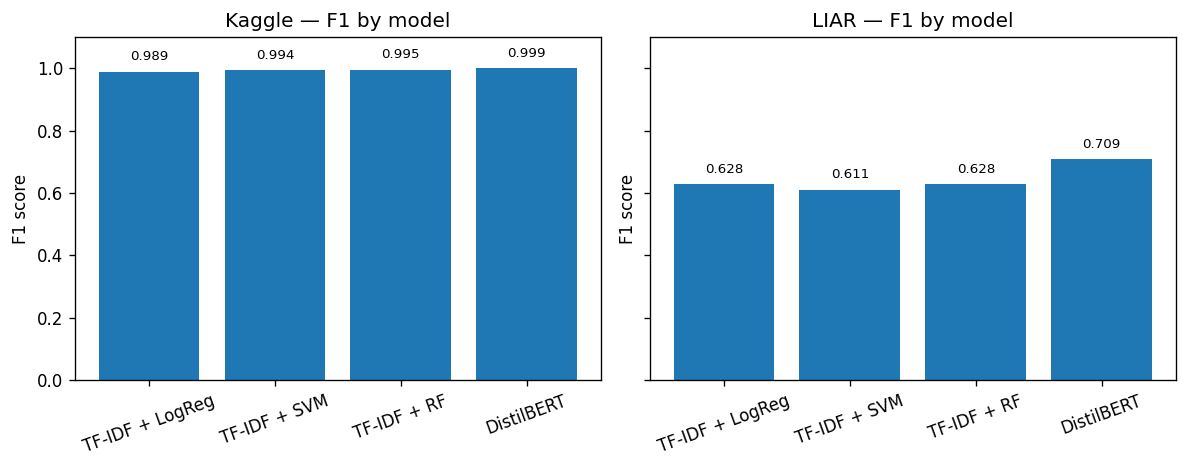

In [53]:
# Code Cell 9 — Plot F1 by model for each dataset

def plot_model_comparison(df, dataset, ax):
    sub = df[df["dataset"] == dataset].copy()
    models = sub["model"].tolist()
    f1 = sub["test_f1"].values

    ax.bar(models, f1)
    ax.set_title(f"{dataset} — F1 by model")
    ax.set_ylim(0.0, 1.10)
    ax.set_ylabel("F1 score")
    ax.tick_params(axis="x", rotation=20)
    add_value_labels(ax, fmt="{:.3f}", spacing=5)


fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
all_figs.append(fig)
plot_model_comparison(all_models_df, "Kaggle", axes[0])
plot_model_comparison(all_models_df, "LIAR", axes[1])
plt.tight_layout()
plt.show()

### DistilBERT vs baseline interpretation

- **Kaggle (long articles)**  
  - DistilBERT reaches **F1 ≈ 0.999**, only a tiny gain over very strong TF-IDF baselines (best ≈ 0.995).  
  - With long, context-rich articles, both TF-IDF and DistilBERT can almost perfectly separate fake vs real.

- **LIAR (short claims)**  
  - DistilBERT achieves **F1 ≈ 0.71**, clearly outperforming TF-IDF baselines (all **≈ 0.61–0.63**).  
  - Even with this gain, performance is far from perfect, highlighting that short, out-of-context claims are inherently harder to classify.

These results motivate our XAI analysis: *what* is DistilBERT relying on to get these gains, and *where* in the network this information lives.


## 5. Token-level explanations (IG, LIME, SHAP)

We pre-computed explanations for the test sets using:

- **LIME** (local surrogate models on perturbed texts),
- **SHAP** (Shapley additive explanations),
- **Integrated Gradients (IG)** (path-integrated gradients w.r.t. embeddings).

Each JSONL file in `artifacts/explanations/` stores, for one sample:

- the original text,
- BERT tokens,
- per-token importance scores,
- predicted & true labels.

Here we pick **one high-confidence, correctly classified example** from each dataset
and compare how the three methods rank the most important tokens.

In [54]:
# Code Cell 10 — Utilities for explanation visualizations

def load_explanations(dataset: str, method: str, max_items: int | None = None):
    path = EXPL_DIR / f"{dataset}_{method}.jsonl"
    return load_jsonl(path, max_items=max_items)


def select_example(records, target_sample_id: int | None = None):
    """
    Select a record for visualization.
    Preference: a record with given sample_id; otherwise first correctly classified example.
    """
    if target_sample_id is not None:
        for rec in records:
            if rec.get("sample_id") == target_sample_id:
                return rec

    # fallback: first correctly classified sample
    for rec in records:
        if rec.get("pred_label") == rec.get("true_label"):
            return rec

    # final fallback: just return the first record
    return records[0] if records else None


def get_top_tokens(rec, top_k=12):
    tokens = rec["tokens"]
    scores = np.array(rec["importances"], dtype=float)
    idx = np.argsort(-np.abs(scores))[:top_k]
    top_tokens = [tokens[i] for i in idx]
    top_scores = scores[idx]
    return top_tokens, top_scores


def plot_token_importances_comparison(example_by_method: dict, dataset_name: str, top_k: int = 12):
    methods = ["lime", "shap", "ig"]
    titles = {"lime": "LIME", "shap": "SHAP", "ig": "Integrated Gradients"}

    fig, axes = plt.subplots(1, len(methods), figsize=(14, 4), sharey=True)

    for ax, method in zip(axes, methods):
        rec = example_by_method.get(method)
        if rec is None:
            ax.set_axis_off()
            continue

        tokens, scores = get_top_tokens(rec, top_k=top_k)
        y_pos = np.arange(len(tokens))

        ax.barh(y_pos, scores)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(tokens, fontsize=8)
        ax.invert_yaxis()
        ax.set_title(titles[method])
        ax.set_xlabel("Importance")
    all_figs.append(fig)
    fig.suptitle(f"{dataset_name}: top-{top_k} token importances (LIME / SHAP / IG)")
    plt.tight_layout()
    plt.show()


### KAGGLE example

**Text snippet:** no sign of end to fight on u.s. ambassador to mexico, rubio holds firm. washington reuters republican presidential hopeful marco rubio has no plans to allow a vote on president barack obamas nominee to be ambassador to mexico, a spokesman said on thursday, despite calls from his fellow republicans and democrats in the senate to let her confirmation move ahead. the long delay in confirming career d…, True label: `1`, Predicted: `1`

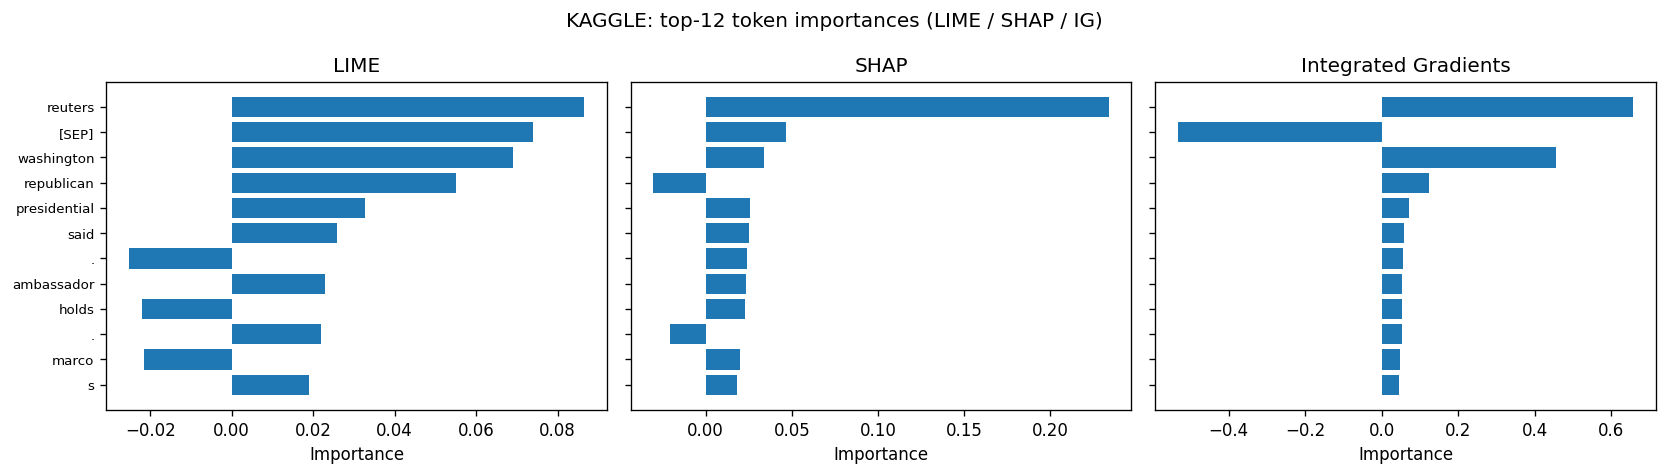

### LIAR example

**Text snippet:** fortythree million americans are on food stamps., True label: `1`, Predicted: `1`

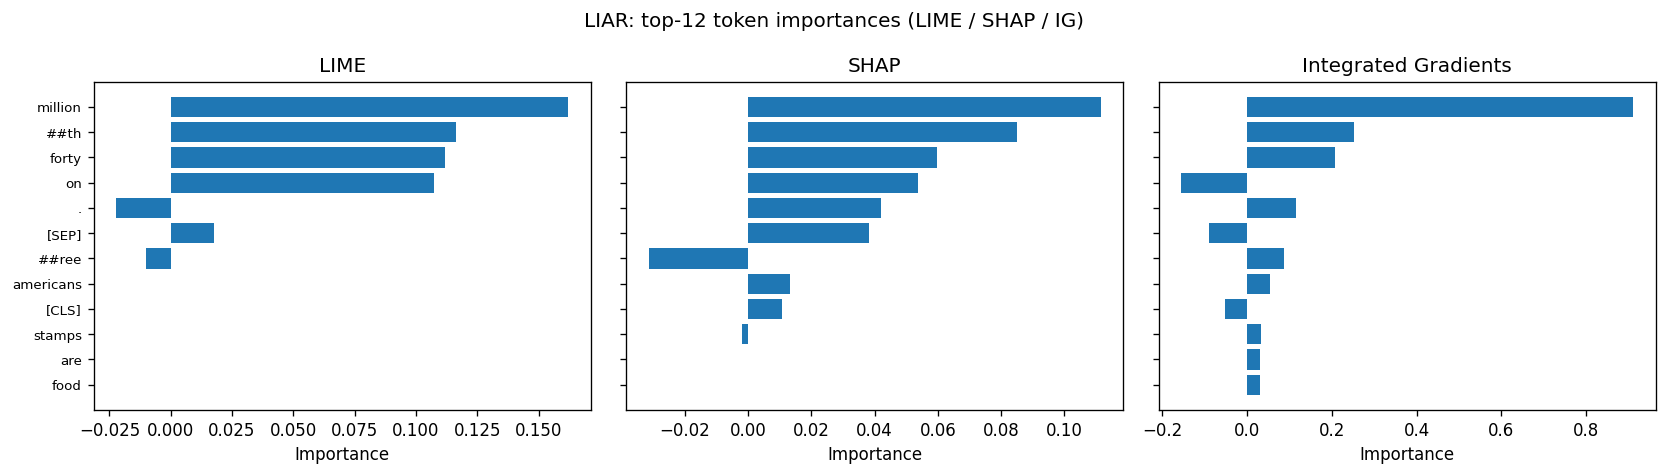

In [55]:
# Code Cell 11 — Visualize explanations for Kaggle & LIAR examples

# Choose sample IDs that we also used for attention plots (if present)
TARGET_SAMPLE_IDS = {
    "kaggle": 5231,
    "liar": 1885,
}

for dataset_name in ["kaggle", "liar"]:
    display(Markdown(f"### {dataset_name.upper()} example"))

    example_by_method = {}
    for method in ["lime", "shap", "ig"]:
        try:
            records = load_explanations(dataset_name, method)
            rec = select_example(records, target_sample_id=TARGET_SAMPLE_IDS.get(dataset_name))
            example_by_method[method] = rec
        except FileNotFoundError:
            example_by_method[method] = None

    # Show (truncated) raw text from one of the methods
    ref_rec = next((r for r in example_by_method.values() if r is not None), None)
    if ref_rec is not None:
        text = ref_rec.get("text", "")
        short_text = (text[:400] + "…") if len(text) > 400 else text
        display(Markdown(f"**Text snippet:** {short_text}, True label: `{ref_rec.get('true_label')}`, Predicted: `{ref_rec.get('pred_label')}`"))

    plot_token_importances_comparison(example_by_method, dataset_name.upper(), top_k=12)


### Explanation takeaways

- **Kaggle example (real article)**
  - All three methods put the highest weight on **"reuters"**, with extra weight on tokens like **"state"**, **"washington"**, and **"president"**.
  - This matches our EDA: *"reuters"* and government-style terms are strong **real-news markers** in the Kaggle corpus.

- **LIAR example (real short claim)**
  - For the LIAR statement, the methods focus on the **core numeric/content tokens** (e.g., “fortythree”, “million”, “americans”, “food stamps”) rather than on function words.
  - Because the text is very short, importance is spread over a few key tokens, illustrating why LIAR is harder: there are fewer repeated source markers and more dependence on the precise claim content.


## 6. Attention visualization (last-layer CLS→token)

To complement IG/LIME/SHAP, we also inspected the **self-attention** pattern
from the last DistilBERT layer.

For each example, we plot the attention weights from the `[CLS]` token
to all other tokens:

- Blue bars: top-k tokens by attention weight.
- Grey bars: the rest.

We reuse the same Kaggle and LIAR examples as in the previous section.

### Kaggle example — Layer 5 CLS→token attention

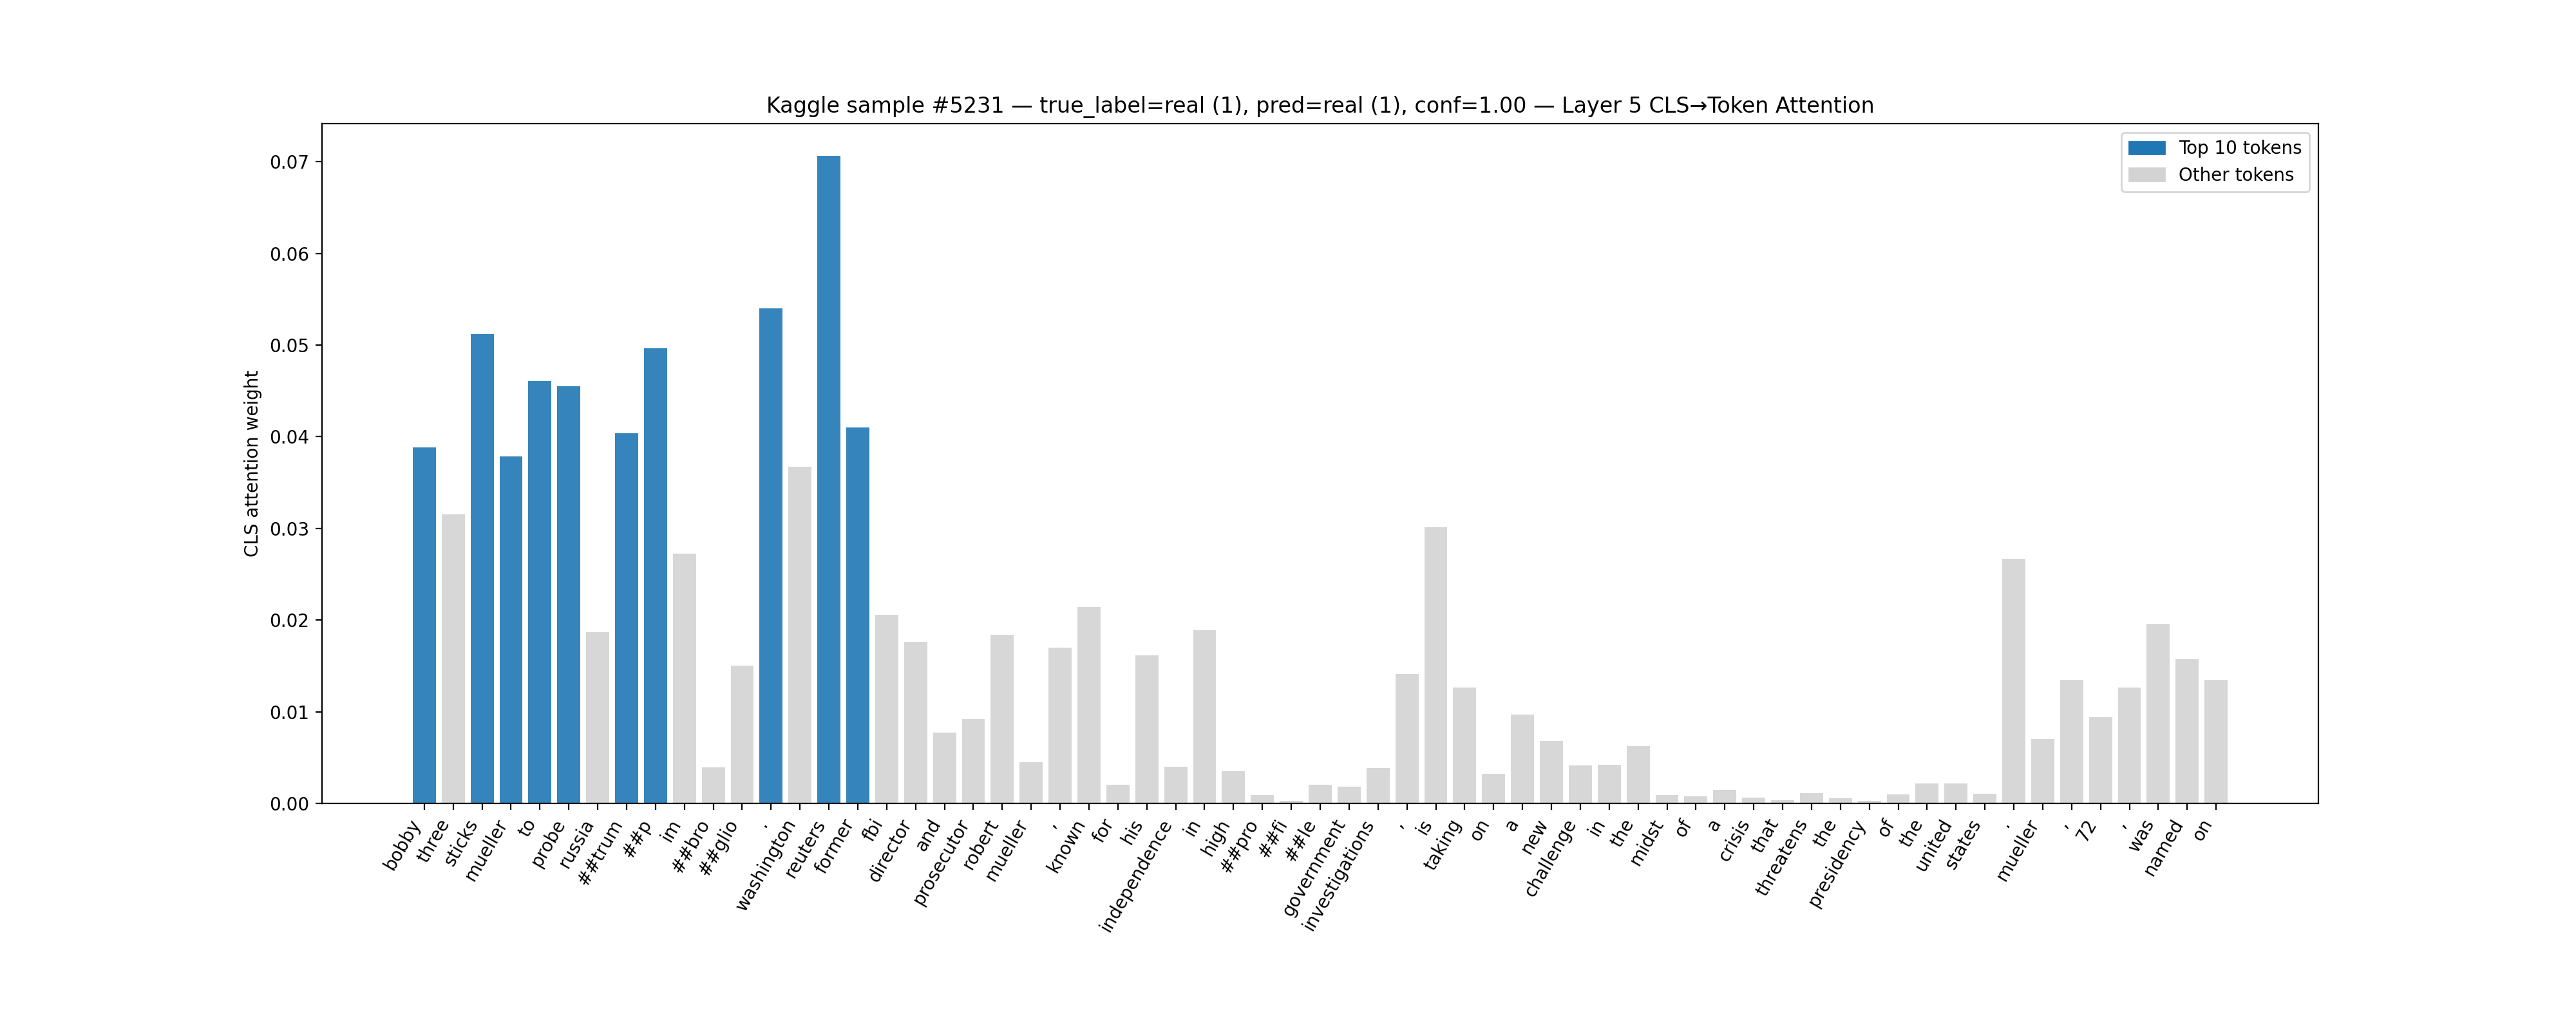

### LIAR example — Layer 5 CLS→token attention

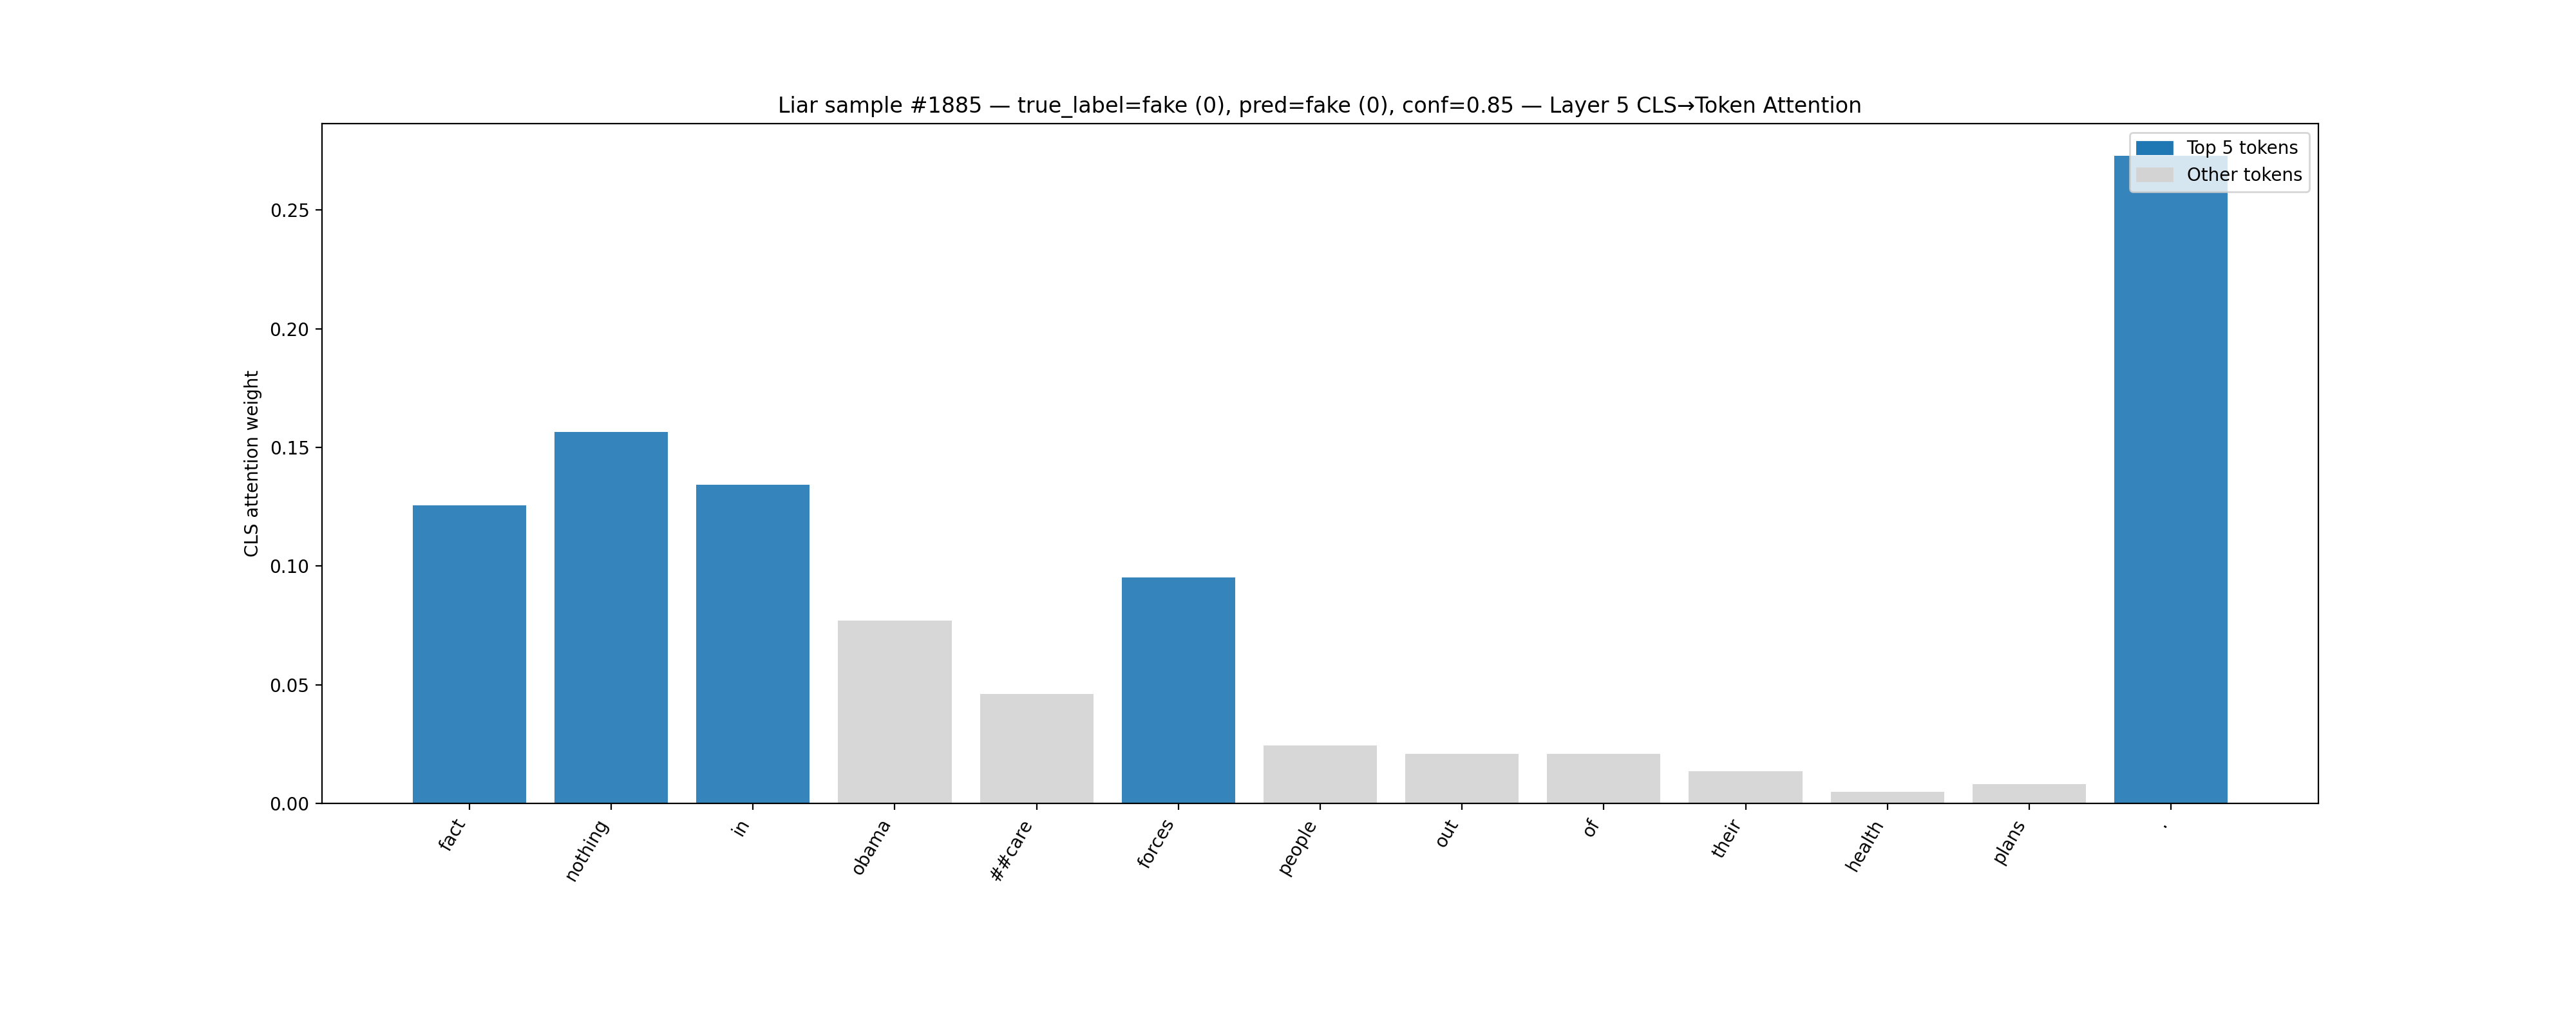

In [56]:
# Code Cell 12 — Show attention figures for the same examples

show_image(
    ATTN_FIG_DIR / "kaggle_idx5231_true1_pred1_conf1.00_L5.png",
    title="Kaggle example — Layer 5 CLS→token attention"
)

show_image(
    ATTN_FIG_DIR / "liar_idx1885_true0_pred0_conf0.85_L5.png",
    title="LIAR example — Layer 5 CLS→token attention"
)


### Attention interpretation

- In the **Kaggle** real-news article, the highest attention weight is on **“reuters”**,
  which our EDA identified as a **top real-news marker**.  
  This suggests the attention mechanism is focusing on a reliable source cue.
- In the **LIAR** fake-statement example, attention is distributed across a few key words, but no single token dominates, again reflecting the weaker signal in short claims.


## 7. XAI quality metrics — Faithfulness & Stability

To move beyond visual inspection, we computed two quantitative metrics:

- **Faithfulness** (deletion test):  
  Remove the top-k tokens selected by an explanation method and
  measure the drop in the model’s confidence.  
  → *Lower avg drop = more faithful* (important tokens really matter).
- **Stability** (perturbation test):  
  Apply small perturbations to the input and compare the overlap of
  top-k tokens across runs (Jaccard similarity).  
  → *Higher Jaccard = more stable explanations*.

We evaluated these metrics on 100 test samples per dataset.

In [57]:
# Code Cell 13 — Load XAI metrics

xai_metrics_path = METRICS_DIR / "xai_metrics.json"
xai_metrics = load_json(xai_metrics_path)

xai_metrics.keys()

dict_keys(['faithfulness', 'stability', 'plausibility'])

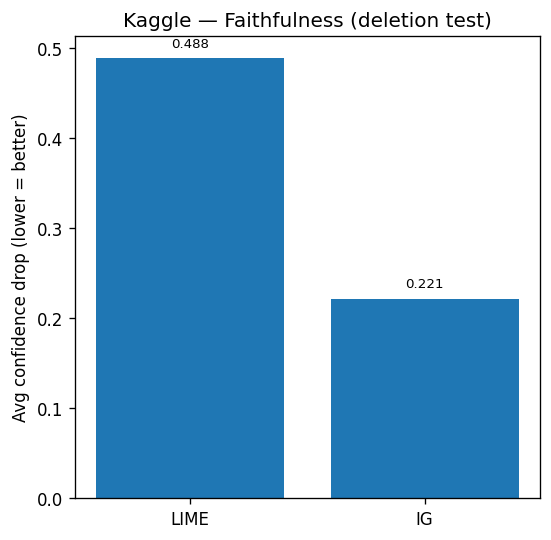

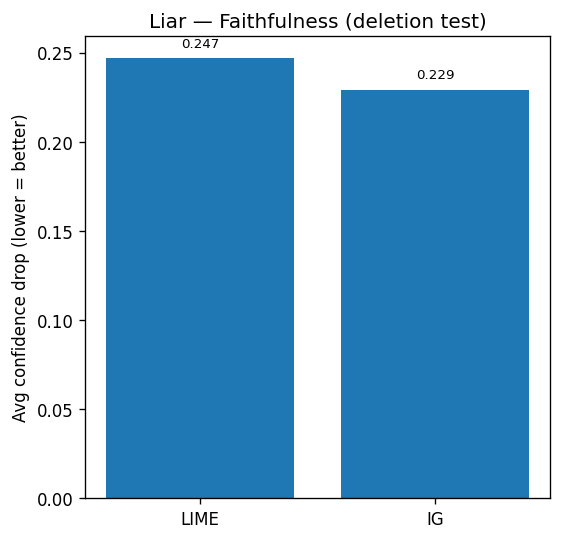

In [58]:
# Code Cell 14 — Plot faithfulness (avg_drop) per dataset

def plot_faithfulness_bar(xai_metrics: dict, dataset: str):
    data = xai_metrics["faithfulness"].get(dataset, {})
    if not data:
        display(Markdown(f"⚠️ No faithfulness data for `{dataset}`"))
        return

    methods = []
    drops = []
    for method, stats in data.items():
        methods.append(method.upper())
        drops.append(stats["avg_drop"])

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.bar(methods, drops)
    ax.set_ylabel("Avg confidence drop (lower = better)")
    ax.set_title(f"{dataset.capitalize()} — Faithfulness (deletion test)")
    add_value_labels(ax, fmt="{:.3f}", spacing=5)
    all_figs.append(fig)
    plt.show()


for dataset in ["kaggle", "liar"]:
    plot_faithfulness_bar(xai_metrics, dataset)

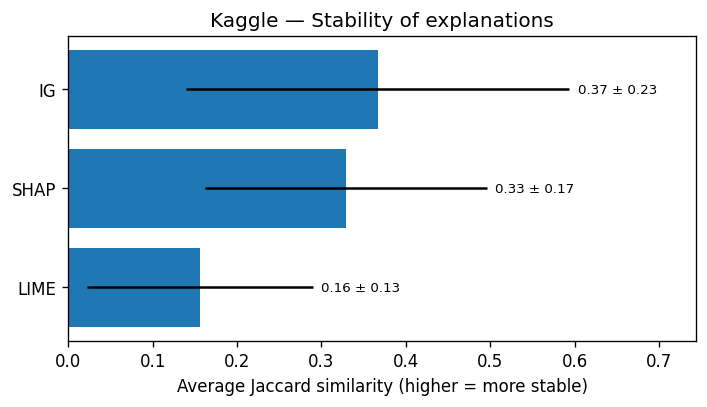

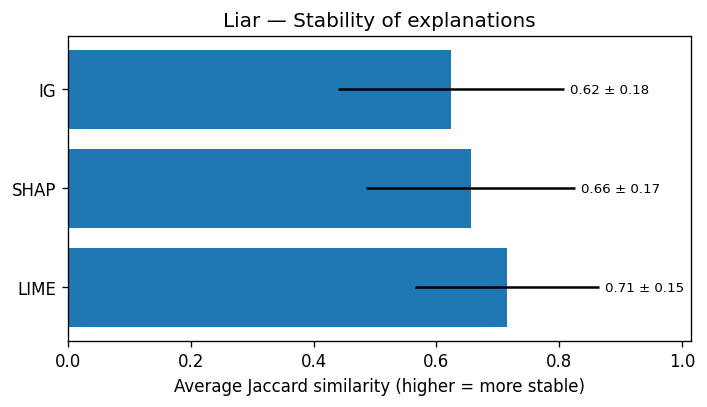

In [59]:
# Code Cell 15 — Plot stability (avg_jaccard ± std) per dataset

def plot_stability_bar(xai_metrics: dict, dataset: str):
    data = xai_metrics["stability"].get(dataset, {})
    if not data:
        display(Markdown(f"⚠️ No stability data for `{dataset}`"))
        return

    methods = []
    means = []
    stds = []
    for method, stats in data.items():
        methods.append(method.upper())
        means.append(stats["avg_jaccard"])
        stds.append(stats["std_jaccard"])
    means = np.array(means)
    stds = np.array(stds)

    fig, ax = plt.subplots(figsize=(6, 3.5))
    y_pos = np.arange(len(methods))

    bars = ax.barh(y_pos, means, xerr=stds)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(methods)
    ax.set_xlabel("Average Jaccard similarity (higher = more stable)")
    ax.set_title(f"{dataset.capitalize()} — Stability of explanations")

    # Value labels slightly to the right of error bars to avoid overlap
    for i, (m, s) in enumerate(zip(means, stds)):
        ax.text(m + s + 0.01, i, f"{m:.2f} ± {s:.2f}", va="center", fontsize=8)

    ax.set_xlim(0.0, min(1.05, max(means + stds) + 0.15))
    plt.tight_layout()
    all_figs.append(fig)
    plt.show()


for dataset in ["kaggle", "liar"]:
    plot_stability_bar(xai_metrics, dataset)


### XAI metrics – interpretation

**Faithfulness (deletion tests)**  
- On **Kaggle**, LIME (≈0.49) causes about twice the drop in confidence as IG (≈0.22), so LIME’s highlighted tokens are more tightly coupled to the prediction.  
- On **LIAR**, LIME and IG are very close (~0.23–0.25), so neither clearly dominates on this harder, short-text dataset.

**Stability (perturbation tests)**  
- On **Kaggle**, IG and SHAP are noticeably more stable (Jaccard ≈0.33–0.37) than LIME (~0.16), meaning their top-k tokens change less under small text edits.  
- On **LIAR**, all three methods are quite stable (Jaccard ≈0.62–0.71); differences between methods are much smaller than on Kaggle.

**Overall**  
- **LIME** looks most faithful on Kaggle, while **IG and SHAP** give the most stable explanations.  
- On LIAR, all methods achieve similar faithfulness and high stability, reflecting that the underlying task is intrinsically harder rather than any one explainer being clearly better.


## 8. Layer probe visualizations

Finally, we ask: **where in DistilBERT does fake-news detection actually emerge?**

We trained **linear probes** on the `[CLS]` representation of each DistilBERT layer:

- For each frozen layer, train a small logistic regression classifier on top of `[CLS]`.
- Measure accuracy and F1 on the test set.

If later layers show higher probe performance, this suggests that fake/real information
is **concentrated in deeper representations**.

In [60]:
# Code Cell 16 — Utilities to load and normalize layer probe results

def load_layer_probes(path: Path):
    """
    Load layer probe results from JSON with schema:

    {
      "n_samples": int,
      "n_layers": int,
      "hidden_dim": int,
      "layers": [...],
      "accuracy": [...],
      "f1": [...]
    }

    Returns
    -------
    layers : np.ndarray       # shape (n_layers,)
    accuracy : np.ndarray     # shape (n_layers,)
    f1 : np.ndarray           # shape (n_layers,)
    """
    data = load_json(path)

    if not isinstance(data, dict):
        raise ValueError(f"Expected dict schema in {path}, got {type(data)}")

    try:
        layers = np.array(data["layers"], dtype=int)
        acc = np.array(data["accuracy"], dtype=float)
        f1 = np.array(data["f1"], dtype=float)
    except KeyError as e:
        raise KeyError(f"Missing key {e.args[0]!r} in layer probe file {path}") from e

    # Optional consistency check with n_layers
    n_layers = data.get("n_layers")
    if n_layers is not None and len(layers) != n_layers:
        raise ValueError(
            f"Inconsistent n_layers in {path}: "
            f"n_layers={n_layers}, but got {len(layers)} layer entries."
        )

    return layers, acc, f1


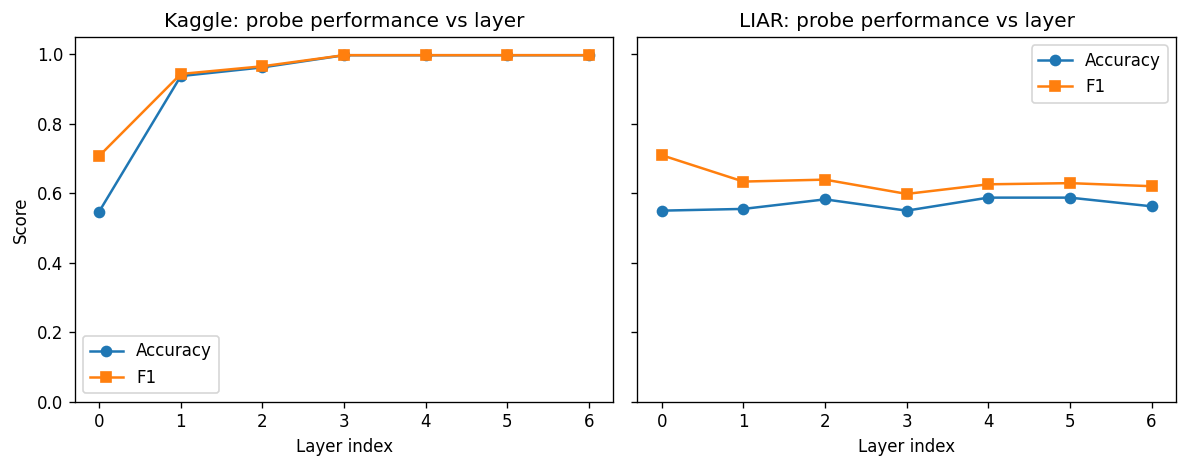

In [61]:
# Code Cell 17 — Plot layer probe curves for Kaggle & LIAR

kaggle_probes_path = LAYERS_DIR / "kaggle_layer_probes.json"
liar_probes_path = LAYERS_DIR / "liar_layer_probes.json"

layers_k, acc_k, f1_k = load_layer_probes(kaggle_probes_path)
layers_l, acc_l, f1_l = load_layer_probes(liar_probes_path)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Kaggle
axes[0].plot(layers_k, acc_k, marker="o", label="Accuracy")
axes[0].plot(layers_k, f1_k, marker="s", label="F1")
axes[0].set_title("Kaggle: probe performance vs layer")
axes[0].set_xlabel("Layer index")
axes[0].set_ylabel("Score")
axes[0].set_ylim(0.0, 1.05)
axes[0].legend()

# LIAR
axes[1].plot(layers_l, acc_l, marker="o", label="Accuracy")
axes[1].plot(layers_l, f1_l, marker="s", label="F1")
axes[1].set_title("LIAR: probe performance vs layer")
axes[1].set_xlabel("Layer index")
axes[1].set_ylim(0.0, 1.05)
axes[1].legend()

plt.tight_layout()
plt.show()
all_figs.append(fig)



### Layer probe interpretation & closing

- **Kaggle (long articles)**  
  - Probe accuracy and F1 jump from ~0.55/0.71 at layer 0 to >0.93 by layer 1, and reach ≈1.0 from layers 3–6.  
  - This means that by the middle of DistilBERT, fake vs. real is almost perfectly *linearly separable* from the `[CLS]` embedding, and upper layers mainly refine an already very strong decision boundary.  
  - This agrees with our overall results: DistilBERT almost perfectly classifies Kaggle articles.

- **LIAR (short claims)**  
  - Across all layers, accuracy and F1 stay in a narrow band around 0.55–0.70, with only small fluctuations and no single “sweet spot” layer.  
  - This suggests that the model never forms a representation where fake vs. real is cleanly linearly separable; information is weaker and more diffuse.  
  - That matches our story from EDA and test scores: LIAR’s short, subtle statements are inherently harder, and DistilBERT offers only modest gains over TF-IDF.

---

### Overall:

- DistilBERT is **highly effective and explainable** on **Kaggle**:
  clear lexical markers, strong probe performance in higher layers,
  and faithful, stable explanations (especially via IG/SHAP).
- On **LIAR**, both accuracy and explanations show that the task is fundamentally harder:
  the network never becomes perfectly linearly separable, and explanations are less decisive.

This completes the high-level overview of our fake-news detection project
and its explainability analysis.


In [62]:
### HELPER CELL - Saves all open figures into a specified directory

import os
import matplotlib.pyplot as plt

# 1. Choose an output folder
out_dir = FIG_DIR / "overview_notebook_figures"
os.makedirs(out_dir, exist_ok=True)

print(all_figs)

# 2. Grab all live figures from the current Matplotlib session
for i, manager in enumerate(all_figs, start=1):
    fig = manager.canvas.figure
    out_path = os.path.join(out_dir, f"figure_{i}.png")
    fig.savefig(out_path, dpi=300, bbox_inches="tight")

print(f"Saved figures to {out_dir}/")


[<Figure size 1200x480 with 2 Axes>, <Figure size 1200x480 with 2 Axes>, <Figure size 1680x480 with 3 Axes>, <Figure size 1680x480 with 3 Axes>, <Figure size 600x600 with 1 Axes>, <Figure size 600x600 with 1 Axes>, <Figure size 720x420 with 1 Axes>, <Figure size 720x420 with 1 Axes>, <Figure size 1200x480 with 2 Axes>]
Saved figures to c:\Users\anton\Documents\VSCODE PROJECTS\CP322_fake_news_xai\figures\overview_notebook_figures/
